# Preparação do Ambiente

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from collections import defaultdict

In [3]:
def argmax(arr):
   return np.random.choice(np.flatnonzero(arr == arr.max()))

In [4]:
def plot_rewards(train_rewards, test_rewards=None, title=None, max_reward=None):
    if test_rewards is not None:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    
    axes[0].plot(train_rewards)
    axes[0].set_title("Training")
    axes[0].set_xlabel("Episodes")
    axes[0].set_ylabel("Mean Reward")
    
    if test_rewards is not None:
        axes[1].plot(test_rewards)
        axes[1].set_title("Testing")
        axes[1].set_xlabel("Episodes")
        axes[1].set_ylabel("Mean Reward")
    
    if max_reward is not None:
        axes[0].axhline(max_reward, color='r', linestyle='--')
        
        if test_rewards is not None:
            axes[1].axhline(max_reward, color='r', linestyle='--')
        
    fig.suptitle(title)
    plt.show()

In [5]:
def plot_q_table(q_table, title=None):
   if all(isinstance(s, int) for s in q_table.keys()):
      num_states = max(q_table.keys()) + 1
      num_actions = len(next(iter(q_table.values())))
      matrix = np.zeros((num_states, num_actions))
      for s, actions in q_table.items():
         matrix[s] = actions
      plt.figure(figsize=(10, 5))
      sns.heatmap(matrix, annot=True)
      plt.xlabel("Action")
      plt.ylabel("State")
      plt.title(title)
      plt.show()
   else:
      print("Não é possível plotar Q-table: estados não são inteiros.")

# Definição do Agente


In [ ]:
class QLearningAgent:
   def __init__(self, env,
                epsilon=0.99, 
                alpha=0.1,
                gamma=0.99,
                epsilon_decay=0.999,
                epsilon_min=0.01):
      self.env = env
      self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
      self.epsilon = epsilon
      self.alpha = alpha
      self.gamma = gamma
      self.epsilon_decay = epsilon_decay
      self.epsilon_min = epsilon_min
   
   def act(self, state):
      if np.random.rand() < self.epsilon:
         return self.env.action_space.sample()
      return argmax(self.q_table[state])

   def update(self, state, action, reward, next_state, done):
      next_best_action = argmax(self.q_table[next_state])
      
      target = reward + self.gamma * self.q_table[next_state][next_best_action] * (1 - int(done))
      error = target - self.q_table[state][action]
      self.q_table[state][action] += self.alpha * error
      
      if done:
         self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
   
   def train(self, episodes, verbose=False):
      progress = tqdm(range(1, episodes + 1), desc="Training", disable=not verbose)
      total_reward = 0
      rewards = []
      
      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False
         
         while not done:
            action = self.act(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            self.update(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            
         total_reward += episode_reward
         rewards.append(total_reward / episode)
         progress.set_postfix({"Reward": total_reward / episode, "Epsilon": self.epsilon})
      
      return rewards
   
   def evaluate(self, episodes, verbose=False):
      progress = tqdm(range(1, episodes + 1), desc="Evaluating", disable=not verbose)
      total_reward = 0
      rewards = []
      
      real_epsilon = self.epsilon
      self.epsilon = 0
      
      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False
         
         while not done:
            action = self.act(state)
            state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            episode_reward += reward
            
         total_reward += episode_reward
         rewards.append(total_reward / episode)
         progress.set_postfix({"Reward": total_reward / episode})
      
      self.epsilon = real_epsilon
      
      return rewards
         
   def save(self, path):
      q_table_dict = dict(self.q_table)
      np.save(path, q_table_dict, allow_pickle=True)
      
   def load(self, path):
      loaded = np.load(path, allow_pickle=True).item()
      self.q_table = defaultdict(lambda: np.zeros(self.env.action_space.n), loaded)

# Ambientes

In [7]:
envs = [
    ("Blackjack-v1",     "Blackjack",        "blackjack.npy",       1),
    ("Taxi-v3",          "Taxi",             "taxi.npy",            20),
    ("CliffWalking-v0",  "Cliff Walking",    "cliff_walking.npy",   -13), 
    ("FrozenLake-v1",    "Frozen Lake",      "frozen_lake.npy",     1),
]


Training Blackjack...


Training:   0%|          | 0/10000 [00:00<?, ?it/s, Reward=0.25, Epsilon=0.989] 

Evaluating: 100%|██████████| 1000/1000 [00:01<00:00, 940.54it/s, Reward=-0.094]


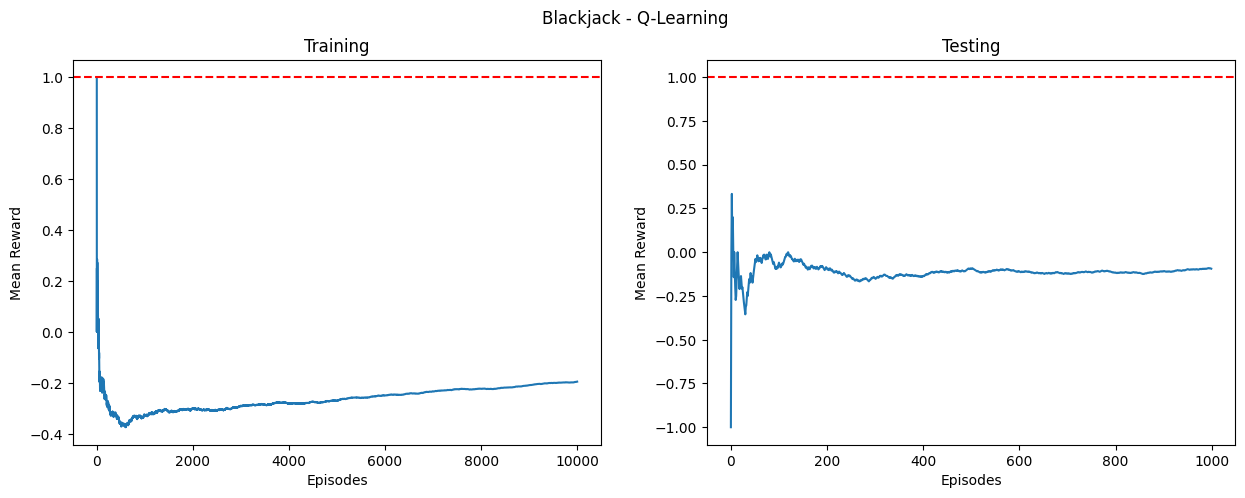

Não é possível plotar Q-table: estados não são inteiros.
Done!

Training Taxi...


Evaluating: 100%|██████████| 1000/1000 [00:01<00:00, 722.22it/s, Reward=8.03]


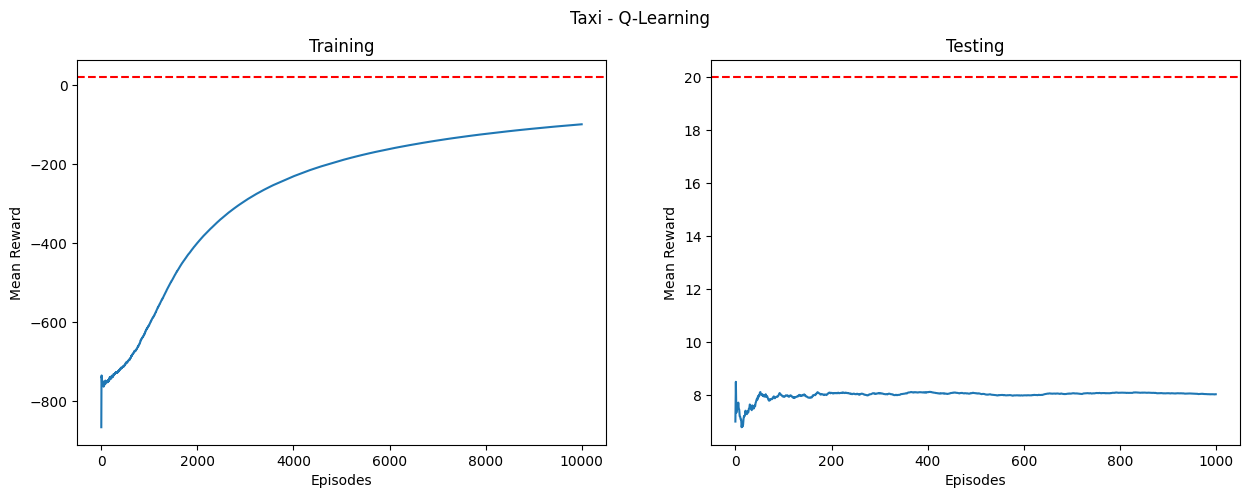

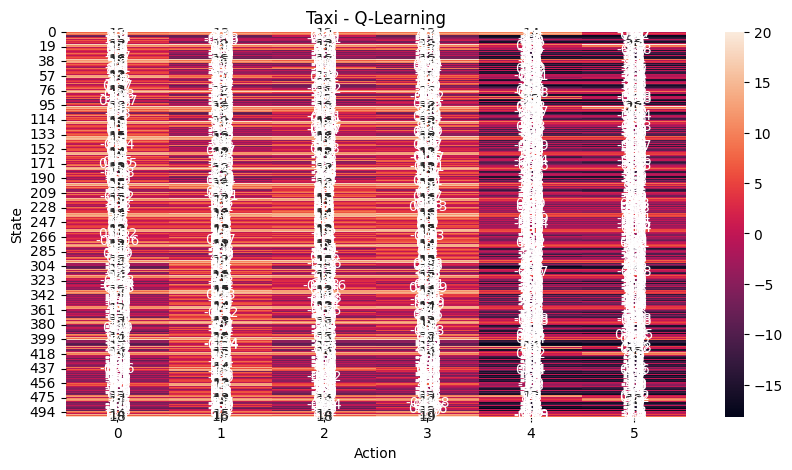

Done!

Training Cliff Walking...


Evaluating: 100%|██████████| 1000/1000 [00:01<00:00, 737.48it/s, Reward=-13]


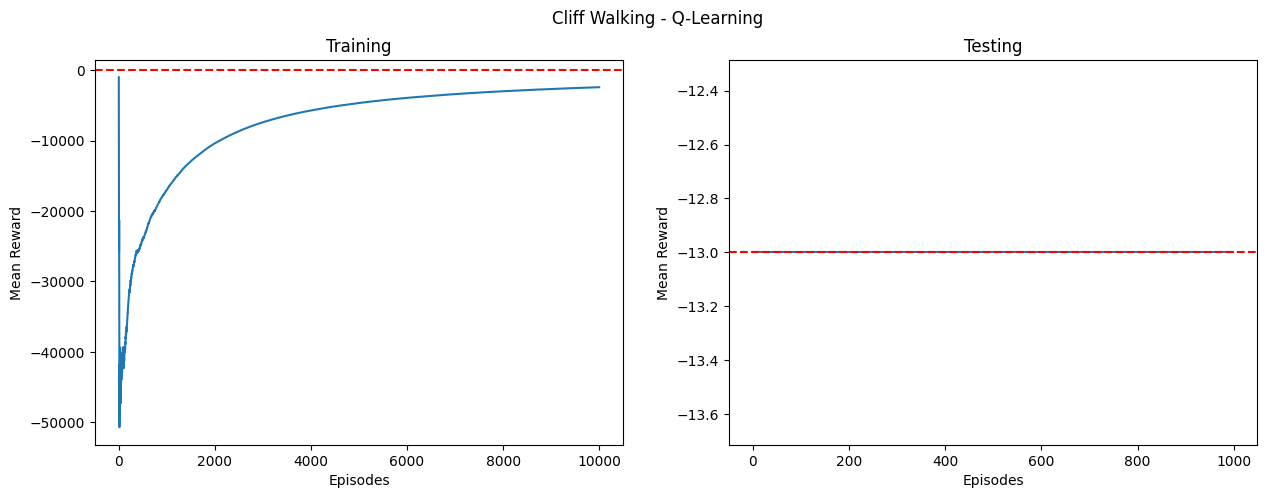

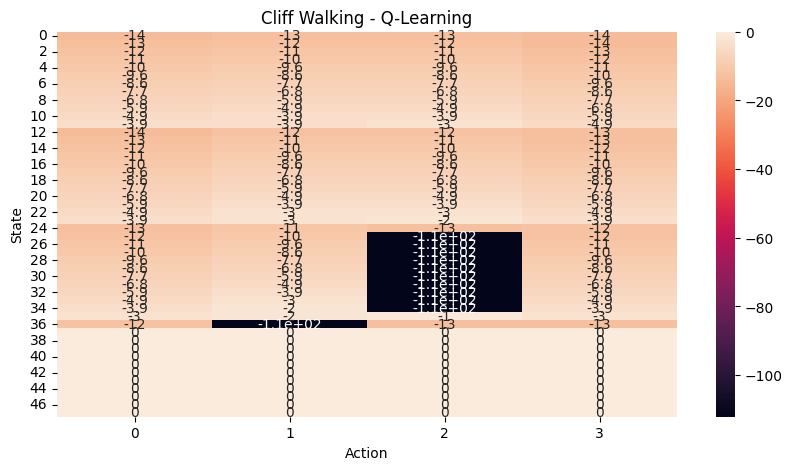

Done!

Training Frozen Lake...


Evaluating: 100%|██████████| 1000/1000 [00:02<00:00, 408.90it/s, Reward=0.743]


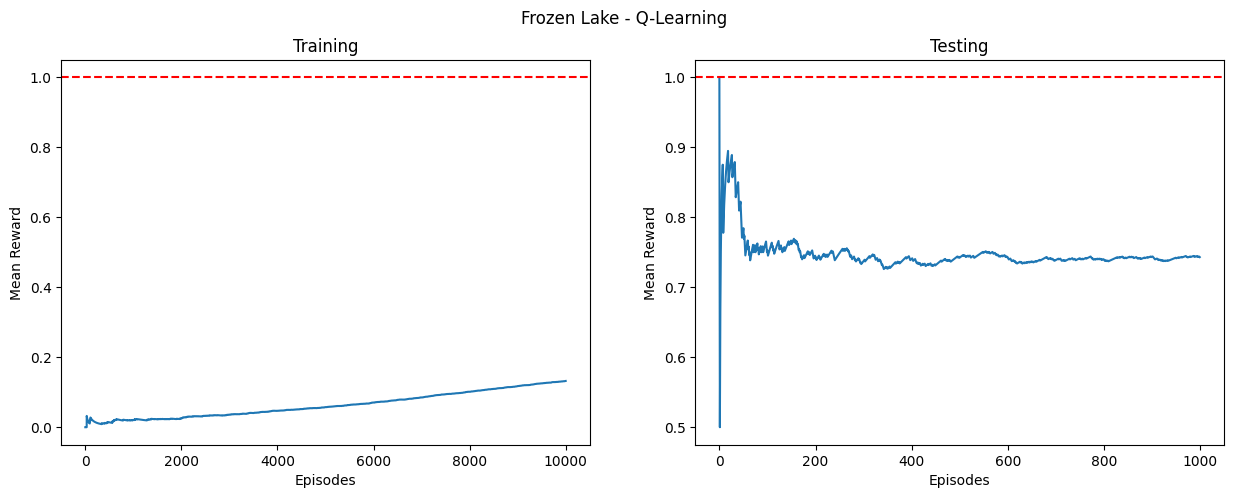

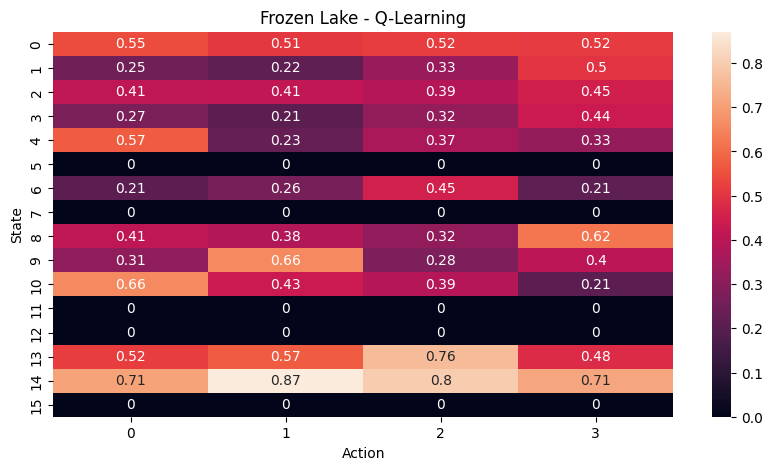

Done!



In [8]:
for env_name, env_title, path, max_reward in envs:
   print(f"Training {env_title}...")
   
   env = gym.make(env_name)
   agent = QLearningAgent(env, epsilon_decay=0.9998)
   
   train_rewards = agent.train(10000, verbose=True)
   test_rewards = agent.evaluate(1000, verbose=True)
   
   agent.save(f'checkpoint/{path}')
   
   plot_rewards(train_rewards, test_rewards, f"{env_title} - Q-Learning", max_reward=max_reward)
   plot_q_table(agent.q_table, f"{env_title} - Q-Learning")
   
   print("Done!\n")